**Implementation of GRU on the time-series dataset**

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping   # ✅ Added this import
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
# Load test features and labels
X_test = np.load('rolling_window_sequences.npy')  # Replace with actual file path
metadata_test = pd.read_csv("sequence_metadata_with_RUL.csv")  # Replace with actual file path
y_test = metadata_test["RUL"].values
print("Test feature shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Test feature shape: (17631, 30, 66)
Test target shape: (17631,)


In [11]:
# Split the data into train and validation sets (assuming no separate train set given)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [12]:
# Define GRU model creation function
def create_gru_model(input_shape, units=64, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

In [13]:
# Create the model
model = create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=64, learning_rate=0.001, dropout_rate=0.2)

# Callbacks for early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 7590.2988 - mae: 75.9206 - val_loss: 5820.5649 - val_mae: 64.7230
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 5547.8691 - mae: 62.8855 - val_loss: 4537.2490 - val_mae: 55.4010
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 4339.9268 - mae: 54.0965 - val_loss: 3556.0090 - val_mae: 48.0000
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 3373.5105 - mae: 46.7393 - val_loss: 2795.4785 - val_mae: 41.9827
Epoch 5/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 2629.0593 - mae: 40.7262 - val_loss: 2160.0415 - val_mae: 36.5282
Epoch 6/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2064.3357 - mae: 35.7768 - val_loss: 1697.3302 - val_mae: 32.3465
Epoch 7/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1622.1998 - mae: 31.7427 - val_loss: 1308.8156 - val_mae: 28.3701
Epoch 8/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1264.9423 - mae: 28.2050 - val_loss: 1031.5898 - v

In [15]:
# Evaluate on validation set
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation MSE: {val_loss:.4f}, MAE: {val_mae:.4f}')

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Calculate test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {test_mse:.4f}')

Validation MSE: 125.4199, MAE: 8.3335
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Test MSE: 111.6356


Task: Build and train a GRU (Gated Recurrent Unit) neural network model for sequence regression on a given dataset. The implementation must include the following features:

Use of callbacks such as EarlyStopping to prevent overfitting and ModelCheckpoint to save the best model.

Hyperparameter tuning for model parameters like number of GRU units, learning rate, and dropout rate.

Cross-validation (e.g., K-Fold) to robustly evaluate model performance across different data splits.

Reporting of evaluation metrics such as mean squared error (MSE) and mean absolute error (MAE). **bold text**

In [16]:
#Import Required Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [17]:
#Load dataset
# Load preprocessed sequences (X) and labels (y)
X = np.load("rolling_window_sequences.npy")   # shape: (samples, timesteps, features)
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (17631, 30, 66)
Target shape: (17631,)


In [18]:
#Define Model Creation Function
def create_gru_model(input_shape, units=64, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Regression output

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


In [19]:
#set hyperparameters
param_grid = {
    "units": [32, 64],          # Try small and medium GRU sizes
    "learning_rate": [0.001, 0.0005],
    "dropout_rate": [0.2, 0.3]
}


In [20]:
#K-Fold Cross-Validation with Callbacks
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

fold_no = 1
results = []

for train_idx, val_idx in kfold.split(X, y):
    print(f"\n----- Fold {fold_no} -----")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Choose hyperparameters (you can loop over param_grid for tuning)
    units = 64
    learning_rate = 0.001
    dropout_rate = 0.2

    model = create_gru_model(
        input_shape=(X.shape[1], X.shape[2]),
        units=units,
        learning_rate=learning_rate,
        dropout_rate=dropout_rate
    )

    # Callbacks
    checkpoint = ModelCheckpoint(f"best_model_fold{fold_no}.h5", save_best_only=True, monitor="val_loss", mode="min")
    earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[checkpoint, earlystop],
        verbose=1
    )

    # Evaluate
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    print(f"Fold {fold_no} - MSE: {mse:.4f}, MAE: {mae:.4f}")
    results.append((mse, mae))

    fold_no += 1



----- Fold 1 -----


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7276.4258 - mae: 73.9697

368/368 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 7268.9072 - mae: 73.9205 - val_loss: 4788.9609 - val_mae: 57.2474
Epoch 2/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4403.1348 - mae: 54.6969

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 4398.9277 - mae: 54.6641 - val_loss: 3002.7505 - val_mae: 43.5955
Epoch 3/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2756.9172 - mae: 41.8755

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2754.4521 - mae: 41.8543 - val_loss: 1898.3517 - val_mae: 34.1706
Epoch 4/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1763.0215 - mae: 33.2200

368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1760.9463 - mae: 33.1993 - val_loss: 1221.8250 - val_mae: 27.4466
Epoch 5/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1175.2354 - mae: 27.2439

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 1174.5273 - mae: 27.2358 - val_loss: 831.4855 - val_mae: 23.1164
Epoch 6/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 798.1282 - mae: 22.8456

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 797.9600 - mae: 22.8432 - val_loss: 590.1479 - val_mae: 19.7233
Epoch 7/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 566.3269 - mae: 19.3636

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 566.0748 - mae: 19.3597 - val_loss: 392.6917 - val_mae: 16.2803
Epoch 8/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 422.2357 - mae: 16.8575

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 422.0354 - mae: 16.8532 - val_loss: 310.2152 - val_mae: 14.2570
Epoch 9/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 332.7253 - mae: 14.9339

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 332.6441 - mae: 14.9316 - val_loss: 246.3212 - val_mae: 12.8129
Epoch 10/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 288.3110 - mae: 13.6787

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 288.2239 - mae: 13.6760 - val_loss: 211.6121 - val_mae: 11.8274
Epoch 11/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 249.9725 - mae: 12.5782 - val_loss: 211.6594 - val_mae: 11.7564
Epoch 12/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 234.6522 - mae: 12.0361

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 234.6230 - mae: 12.0349 - val_loss: 167.4266 - val_mae: 9.7966
Epoch 13/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 212.8227 - mae: 11.2338

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 212.8168 - mae: 11.2334 - val_loss: 162.8719 - val_mae: 9.8160
Epoch 14/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 202.6236 - mae: 11.0489 - val_loss: 223.6886 - val_mae: 10.8610
Epoch 15/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 206.1593 - mae: 10.9844

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 206.0873 - mae: 10.9826 - val_loss: 144.1049 - val_mae: 8.9924
Epoch 16/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 188.8158 - mae: 10.4552

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 188.8219 - mae: 10.4553 - val_loss: 137.6716 - val_mae: 8.8312
Epoch 17/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 179.4916 - mae: 10.2285

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 179.4930 - mae: 10.2284 - val_loss: 134.2560 - val_mae: 8.5245
Epoch 18/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 172.5295 - mae: 9.9649

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 172.5278 - mae: 9.9649 - val_loss: 122.5646 - val_mae: 8.2503
Epoch 19/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 170.6456 - mae: 9.9048 - val_loss: 125.8540 - val_mae: 8.2835
Epoch 20/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 164.1602 - mae: 9.7729

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 164.1653 - mae: 9.7728 - val_loss: 116.4678 - val_mae: 7.8779
Epoch 21/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 156.4027 - mae: 9.4351

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 156.3772 - mae: 9.4347 - val_loss: 114.3562 - val_mae: 7.8548
Epoch 22/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 150.2947 - mae: 9.3372 - val_loss: 120.2946 - val_mae: 8.0040
Epoch 23/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 146.7010 - mae: 9.2091 - val_loss: 124.9553 - val_mae: 8.0682
Epoch 24/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 147.6614 - mae: 9.2454

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 147.6578 - mae: 9.2452 - val_loss: 106.6679 - val_mae: 7.5359
Epoch 25/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 140.0154 - mae: 9.0216 - val_loss: 112.4537 - val_mae: 7.8880
Epoch 26/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 135.9545 - mae: 8.9179

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 135.9440 - mae: 8.9175 - val_loss: 98.8152 - val_mae: 7.2375
Epoch 27/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 127.5476 - mae: 8.6235 - val_loss: 112.5689 - val_mae: 7.8766
Epoch 28/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 124.4967 - mae: 8.5369 - val_loss: 106.9152 - val_mae: 7.5035
Epoch 29/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 130.6519 - mae: 8.7423

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 130.6250 - mae: 8.7414 - val_loss: 81.2244 - val_mae: 6.4911
Epoch 30/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 114.6872 - mae: 8.2407

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 114.7108 - mae: 8.2414 - val_loss: 80.1200 - val_mae: 6.6293
Epoch 31/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 121.6590 - mae: 8.4824 - val_loss: 87.1798 - val_mae: 6.6940
Epoch 32/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 117.0877 - mae: 8.2485

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 117.0806 - mae: 8.2482 - val_loss: 73.4614 - val_mae: 6.1318
Epoch 33/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 108.2585 - mae: 7.9941

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 108.2513 - mae: 7.9936 - val_loss: 71.8451 - val_mae: 6.1007
Epoch 34/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 106.4066 - mae: 7.9566 - val_loss: 79.3356 - val_mae: 6.3695
Epoch 35/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 105.8393 - mae: 7.8981

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 105.8348 - mae: 7.8979 - val_loss: 69.8274 - val_mae: 6.0578
Epoch 36/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 103.9951 - mae: 7.8234 - val_loss: 83.0821 - val_mae: 6.2892
Epoch 37/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104.5300 - mae: 7.8097

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 104.5214 - mae: 7.8093 - val_loss: 65.1350 - val_mae: 5.9383
Epoch 38/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 98.9917 - mae: 7.6091 - val_loss: 65.6486 - val_mae: 5.8763
Epoch 39/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 97.2264 - mae: 7.5674

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 97.2326 - mae: 7.5677 - val_loss: 56.5211 - val_mae: 5.4936
Epoch 40/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 92.9916 - mae: 7.3722 - val_loss: 63.4812 - val_mae: 5.6736
Epoch 41/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 93.4043 - mae: 7.3944 - val_loss: 69.1669 - val_mae: 5.6872
Epoch 42/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 96.6163 - mae: 7.5266 - val_loss: 58.7854 - val_mae: 5.4302
Epoch 43/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 89.7768 - mae: 7.2534

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 89.7973 - mae: 7.2543 - val_loss: 55.4963 - val_mae: 5.3665
Epoch 44/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 89.6151 - mae: 7.2691 - val_loss: 62.4002 - val_mae: 5.7490
Epoch 45/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 91.0132 - mae: 7.2863

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 91.0072 - mae: 7.2862 - val_loss: 53.3242 - val_mae: 5.3062
Epoch 46/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 83.7533 - mae: 7.0336

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 83.7514 - mae: 7.0336 - val_loss: 50.4943 - val_mae: 5.0807
Epoch 47/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 84.4988 - mae: 7.0833 - val_loss: 53.6347 - val_mae: 5.3811
Epoch 48/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 86.3374 - mae: 7.1187 - val_loss: 52.0478 - val_mae: 5.1261
Epoch 49/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 80.6689 - mae: 6.9286

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 80.6772 - mae: 6.9290 - val_loss: 45.5857 - val_mae: 4.7364
Epoch 50/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 83.1634 - mae: 6.9739 - val_loss: 54.5956 - val_mae: 5.3100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Fold 1 - MSE: 45.5857, MAE: 4.7364

----- Fold 2 -----


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6919.0303 - mae: 71.4984

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 6910.1187 - mae: 71.4414 - val_loss: 4743.2280 - val_mae: 57.3650
Epoch 2/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4168.1348 - mae: 52.6550

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 4164.5752 - mae: 52.6284 - val_loss: 2951.1060 - val_mae: 43.5474
Epoch 3/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2616.9729 - mae: 40.4893

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 2615.3613 - mae: 40.4757 - val_loss: 1810.4860 - val_mae: 33.4709
Epoch 4/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1603.4670 - mae: 31.4250

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1601.5520 - mae: 31.4067 - val_loss: 1111.7413 - val_mae: 26.2327
Epoch 5/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 999.2821 - mae: 24.9488 

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 998.2087 - mae: 24.9354 - val_loss: 700.7453 - val_mae: 20.9321
Epoch 6/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 657.8495 - mae: 20.4018

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 657.5928 - mae: 20.3985 - val_loss: 495.0080 - val_mae: 17.9752
Epoch 7/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 468.9506 - mae: 17.4761

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 468.7188 - mae: 17.4724 - val_loss: 363.5883 - val_mae: 15.3821
Epoch 8/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 364.9035 - mae: 15.5263

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 364.8670 - mae: 15.5255 - val_loss: 297.8937 - val_mae: 14.1078
Epoch 9/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 310.3484 - mae: 14.2654

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 310.2966 - mae: 14.2638 - val_loss: 257.0214 - val_mae: 13.0985
Epoch 10/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 259.8555 - mae: 12.8878

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 259.8268 - mae: 12.8866 - val_loss: 209.3052 - val_mae: 11.5260
Epoch 11/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 265.4012 - mae: 12.7237

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 265.2982 - mae: 12.7212 - val_loss: 184.7131 - val_mae: 10.7944
Epoch 12/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 223.9573 - mae: 11.5951

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 223.9316 - mae: 11.5943 - val_loss: 180.4173 - val_mae: 10.1865
Epoch 13/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 203.7274 - mae: 10.9185

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 203.7381 - mae: 10.9188 - val_loss: 160.4240 - val_mae: 9.7522
Epoch 14/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 194.5764 - mae: 10.7206 - val_loss: 252.2565 - val_mae: 11.7984
Epoch 15/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 200.6059 - mae: 10.8130

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 200.5518 - mae: 10.8115 - val_loss: 147.8369 - val_mae: 8.9748
Epoch 16/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 174.8595 - mae: 10.0706 - val_loss: 157.5632 - val_mae: 9.2185
Epoch 17/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 177.8570 - mae: 10.0549

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 177.8282 - mae: 10.0542 - val_loss: 144.1036 - val_mae: 8.6992
Epoch 18/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 170.0672 - mae: 9.8615

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 170.0700 - mae: 9.8612 - val_loss: 127.8008 - val_mae: 8.2916
Epoch 19/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 156.7928 - mae: 9.4818

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 156.8149 - mae: 9.4825 - val_loss: 114.1526 - val_mae: 7.7188
Epoch 20/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 154.1380 - mae: 9.4100 - val_loss: 114.7188 - val_mae: 7.9739
Epoch 21/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 146.6989 - mae: 9.1092

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 146.7662 - mae: 9.1114 - val_loss: 104.9985 - val_mae: 7.4689
Epoch 22/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 152.0366 - mae: 9.2696 - val_loss: 108.4289 - val_mae: 7.5793
Epoch 23/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 143.3521 - mae: 9.0829

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 143.3401 - mae: 9.0824 - val_loss: 103.6499 - val_mae: 7.2559
Epoch 24/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 140.8178 - mae: 9.0111

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 140.8186 - mae: 9.0111 - val_loss: 98.3294 - val_mae: 7.0312
Epoch 25/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 140.8530 - mae: 9.0092

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 140.8357 - mae: 9.0086 - val_loss: 93.8071 - val_mae: 6.9731
Epoch 26/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 127.6897 - mae: 8.5730

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 127.7263 - mae: 8.5740 - val_loss: 91.7364 - val_mae: 6.8376
Epoch 27/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 124.1333 - mae: 8.4215

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 124.2506 - mae: 8.4251 - val_loss: 90.7375 - val_mae: 7.0448
Epoch 28/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 128.2603 - mae: 8.6196

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 128.2362 - mae: 8.6188 - val_loss: 80.8343 - val_mae: 6.2477
Epoch 29/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 123.7466 - mae: 8.4664 - val_loss: 92.3676 - val_mae: 6.8022
Epoch 30/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 125.6487 - mae: 8.4337 - val_loss: 86.4216 - val_mae: 6.6261
Epoch 31/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 115.5766 - mae: 8.2040

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 115.5632 - mae: 8.2036 - val_loss: 78.5433 - val_mae: 6.2632
Epoch 32/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 121.9707 - mae: 8.3071 - val_loss: 80.5559 - val_mae: 6.3308
Epoch 33/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 116.7393 - mae: 8.1721 - val_loss: 118.3135 - val_mae: 7.4835
Epoch 34/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 114.9904 - mae: 8.1983

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 114.9722 - mae: 8.1976 - val_loss: 69.7702 - val_mae: 5.8297
Epoch 35/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 109.8102 - mae: 7.9871 - val_loss: 86.4988 - val_mae: 6.5539
Epoch 36/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 104.8015 - mae: 7.7817 - val_loss: 71.7622 - val_mae: 6.0173
Epoch 37/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 112.2653 - mae: 8.0694

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 112.2496 - mae: 8.0688 - val_loss: 68.9933 - val_mae: 5.5844
Epoch 38/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 102.6510 - mae: 7.7846

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 102.6670 - mae: 7.7849 - val_loss: 65.4026 - val_mae: 5.5738
Epoch 39/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 107.4853 - mae: 7.8686 - val_loss: 89.6585 - val_mae: 6.7205
Epoch 40/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105.3927 - mae: 7.8828

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 105.3668 - mae: 7.8817 - val_loss: 62.0714 - val_mae: 5.5142
Epoch 41/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 92.0874 - mae: 7.3235 - val_loss: 76.5178 - val_mae: 6.1645
Epoch 42/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 99.4540 - mae: 7.6004

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 99.4319 - mae: 7.5996 - val_loss: 59.4934 - val_mae: 5.5614
Epoch 43/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 94.7431 - mae: 7.4824 - val_loss: 69.1143 - val_mae: 5.4431
Epoch 44/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 95.8964 - mae: 7.5036 - val_loss: 62.2707 - val_mae: 5.6676
Epoch 45/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 89.9116 - mae: 7.2445 - val_loss: 60.7242 - val_mae: 5.4448
Epoch 46/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106.3231 - mae: 7.7640

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 106.3260 - mae: 7.7642 - val_loss: 51.1428 - val_mae: 5.0216
Epoch 47/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 87.9641 - mae: 7.1546 - val_loss: 57.8514 - val_mae: 5.4414
Epoch 48/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 87.2886 - mae: 7.1925

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 87.2778 - mae: 7.1921 - val_loss: 48.4275 - val_mae: 4.8130
Epoch 49/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 86.8379 - mae: 7.1562 - val_loss: 53.8616 - val_mae: 5.2391
Epoch 50/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 91.0887 - mae: 7.2841 - val_loss: 55.6149 - val_mae: 5.3403
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Fold 2 - MSE: 48.4275, MAE: 4.8130

----- Fold 3 -----


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7178.0132 - mae: 73.3391

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 7175.3188 - mae: 73.3218 - val_loss: 4664.9160 - val_mae: 56.3148
Epoch 2/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4208.1509 - mae: 53.2597

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 4205.6030 - mae: 53.2402 - val_loss: 2915.8645 - val_mae: 43.1027
Epoch 3/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2611.8245 - mae: 40.6779

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 2609.6707 - mae: 40.6593 - val_loss: 1832.7545 - val_mae: 33.6284
Epoch 4/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1667.9227 - mae: 32.1192

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1667.0074 - mae: 32.1102 - val_loss: 1169.1584 - val_mae: 27.0162
Epoch 5/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1078.0229 - mae: 26.1356

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1076.7111 - mae: 26.1197 - val_loss: 725.2352 - val_mae: 21.4050
Epoch 6/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 702.8182 - mae: 21.2873

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 702.3027 - mae: 21.2801 - val_loss: 505.1252 - val_mae: 17.9879
Epoch 7/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 481.3849 - mae: 17.8165

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 481.2297 - mae: 17.8138 - val_loss: 361.6324 - val_mae: 15.4462
Epoch 8/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 389.7224 - mae: 16.0014

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 389.6923 - mae: 16.0007 - val_loss: 287.9146 - val_mae: 13.7391
Epoch 9/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 331.0642 - mae: 14.6522

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 330.9931 - mae: 14.6503 - val_loss: 251.2558 - val_mae: 12.7745
Epoch 10/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 291.4540 - mae: 13.6125

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 291.3738 - mae: 13.6104 - val_loss: 211.5971 - val_mae: 11.7094
Epoch 11/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 261.8293 - mae: 12.6698

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 261.8079 - mae: 12.6692 - val_loss: 188.3034 - val_mae: 10.7260
Epoch 12/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 243.2569 - mae: 12.1188 - val_loss: 196.2938 - val_mae: 10.6743
Epoch 13/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 225.6076 - mae: 11.5258

368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 225.6030 - mae: 11.5257 - val_loss: 177.0743 - val_mae: 10.0977
Epoch 14/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 214.1350 - mae: 11.2071 - val_loss: 231.9758 - val_mae: 11.0091
Epoch 15/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 206.6956 - mae: 10.9252

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 206.6933 - mae: 10.9251 - val_loss: 159.9895 - val_mae: 9.7638
Epoch 16/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 192.3217 - mae: 10.6877

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 192.3471 - mae: 10.6878 - val_loss: 155.0571 - val_mae: 9.3031
Epoch 17/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 191.4852 - mae: 10.5261

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 191.4503 - mae: 10.5251 - val_loss: 129.0088 - val_mae: 8.5606
Epoch 18/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 178.9236 - mae: 10.2913

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 178.9178 - mae: 10.2909 - val_loss: 115.6666 - val_mae: 8.1481
Epoch 19/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 178.0981 - mae: 10.1012 - val_loss: 123.7472 - val_mae: 8.4521
Epoch 20/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 162.7534 - mae: 9.6585 - val_loss: 134.2243 - val_mae: 8.8239
Epoch 21/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 167.4410 - mae: 9.8474

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 167.4344 - mae: 9.8471 - val_loss: 107.7578 - val_mae: 7.7302
Epoch 22/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 160.4834 - mae: 9.6186

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 160.4603 - mae: 9.6180 - val_loss: 106.1777 - val_mae: 7.6180
Epoch 23/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 157.3543 - mae: 9.4933

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 157.3579 - mae: 9.4934 - val_loss: 105.6436 - val_mae: 7.8652
Epoch 24/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 155.5540 - mae: 9.4612

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 155.5474 - mae: 9.4610 - val_loss: 93.4969 - val_mae: 7.2149
Epoch 25/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 153.6056 - mae: 9.4096 - val_loss: 103.0514 - val_mae: 7.3223
Epoch 26/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 149.9247 - mae: 9.2656 - val_loss: 113.3086 - val_mae: 7.8996
Epoch 27/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 137.9172 - mae: 8.9760

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 137.9253 - mae: 8.9760 - val_loss: 83.7488 - val_mae: 6.7543
Epoch 28/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 136.7511 - mae: 8.8937 - val_loss: 114.4881 - val_mae: 7.7342
Epoch 29/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 144.0326 - mae: 9.0498

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 144.0239 - mae: 9.0497 - val_loss: 80.7358 - val_mae: 6.5844
Epoch 30/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 134.5722 - mae: 8.8068 - val_loss: 86.9143 - val_mae: 6.8893
Epoch 31/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 131.4220 - mae: 8.7856

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 131.4091 - mae: 8.7846 - val_loss: 78.5222 - val_mae: 6.3806
Epoch 32/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 124.9852 - mae: 8.4871

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 124.9975 - mae: 8.4878 - val_loss: 75.9633 - val_mae: 6.3706
Epoch 33/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 129.2182 - mae: 8.6047

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 129.1619 - mae: 8.6031 - val_loss: 74.0475 - val_mae: 6.2848
Epoch 34/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 119.4800 - mae: 8.2403

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 119.4922 - mae: 8.2407 - val_loss: 72.3212 - val_mae: 6.2140
Epoch 35/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 118.6102 - mae: 8.3462

368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 118.6132 - mae: 8.3460 - val_loss: 70.3831 - val_mae: 6.0602
Epoch 36/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 114.6005 - mae: 8.1661 - val_loss: 82.5763 - val_mae: 6.6637
Epoch 37/50
366/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 130.1596 - mae: 8.6372

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 130.1430 - mae: 8.6366 - val_loss: 65.6316 - val_mae: 5.8965
Epoch 38/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 113.9828 - mae: 8.0666 - val_loss: 82.7009 - val_mae: 6.6852
Epoch 39/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 122.7256 - mae: 8.4024

368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 122.7132 - mae: 8.4020 - val_loss: 65.2974 - val_mae: 5.8654
Epoch 40/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 112.8607 - mae: 8.0296 - val_loss: 81.3364 - val_mae: 6.6913
Epoch 41/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 113.2294 - mae: 8.0972 - val_loss: 87.4708 - val_mae: 6.5761
Epoch 42/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 111.6752 - mae: 8.0842 - val_loss: 66.1012 - val_mae: 5.8723
Epoch 43/50
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 104.9464 - mae: 7.7723

368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 104.9681 - mae: 7.7731 - val_loss: 60.9063 - val_mae: 5.7177
Epoch 44/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 101.3425 - mae: 7.6564

368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 101.3578 - mae: 7.6569 - val_loss: 59.6433 - val_mae: 5.5076
Epoch 45/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 102.5705 - mae: 7.7193

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 102.5791 - mae: 7.7196 - val_loss: 56.7506 - val_mae: 5.4500
Epoch 46/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 107.3229 - mae: 7.8498

368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 107.3382 - mae: 7.8504 - val_loss: 55.7945 - val_mae: 5.4207
Epoch 47/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 95.5198 - mae: 7.4758 - val_loss: 69.0926 - val_mae: 6.0098
Epoch 48/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 100.1590 - mae: 7.6589 - val_loss: 62.5524 - val_mae: 5.6422
Epoch 49/50
365/368 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 99.5491 - mae: 7.5795

368/368 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 99.5544 - mae: 7.5798 - val_loss: 51.4749 - val_mae: 5.1525
Epoch 50/50
368/368 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 102.3746 - mae: 7.6793 - val_loss: 52.7888 - val_mae: 5.1714
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 3 - MSE: 51.4749, MAE: 5.1525


In [21]:
#Final performance
results = np.array(results)
print("\n===== Cross-Validation Results =====")
print(f"Average MSE: {results[:,0].mean():.4f} ± {results[:,0].std():.4f}")
print(f"Average MAE: {results[:,1].mean():.4f} ± {results[:,1].std():.4f}")



===== Cross-Validation Results =====
Average MSE: 48.4960 ± 2.4048
Average MAE: 4.9006 ± 0.1808


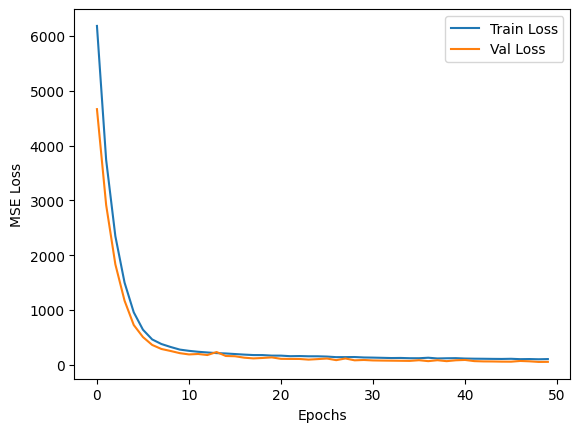

In [22]:
#plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
